In [1]:
import pickle
import sys
sys.path.extend(['C:\\git\\thesis_clean_v2'])
from OriKerasExtension.ThesisHelper import readCompleteMatFile, ExtractDataVer4
from experiments.pretrained_by_colors.color_utils import create_color_dictionary, get_color_from_stimuli
from keras.utils.np_utils import to_categorical
from scipy import stats


In [2]:
results = pickle.load(  open( r"C:\git\thesis_clean_v2\experiments\pretrained_by_colors\save_25_april_predict_color_take_3.p", "rb" ) )

In [3]:
len(results)

11

In [4]:



def downsample_data(data, number_of_original_samples, down_samples_param):
    new_number_of_time_stamps = number_of_original_samples / down_samples_param

    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval

def create_letter_test_data_color(gcd_res, down_samples_param, jitter=20):
    last_time_stamp = 800 + jitter
    fist_time_stamp = -200 +jitter
    color_dictionary = create_color_dictionary()
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)

    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    all_data = temp_data_for_eval[np.all([gcd_res['train_mode'] == 3], axis=0)]

    categorical_tags = to_categorical(
        get_color_from_stimuli(gcd_res['stimulus'][gcd_res['train_mode'] == 3], color_dictionary))
    shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags

In [5]:
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.regularizers import l2



Using Theano backend.
Using gpu device 0: GeForce GT 740M (CNMeM is disabled, CuDNN not available)
C:\Anaconda\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [6]:
"""
define the neural network model:
"""
model_lstm = Sequential()

model_lstm.add(LSTM(input_dim=55, output_dim=20, return_sequences=True))
model_lstm.add(Dropout(0.01))
model_lstm.add(LSTM(input_dim=20, output_dim=20, return_sequences=False))
#     model_lstm.add(Dropout(0.01))
#     model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
model_lstm.add(Dense(5, W_regularizer=l2(0.006)))
model_lstm.add(Activation('softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop',)



In [7]:
import keras
"""
define the neural network model:
"""
model_mpl = Sequential()
model_mpl.add(keras.layers.core.Flatten(input_shape=(55, 25)))
model_mpl.add(Dense(input_dim=55 * 25, output_dim=20))
model_mpl.add(Dropout(0.3))
model_mpl.add(Activation('tanh'))
model_mpl.add(Dense(output_dim=20, W_regularizer=l2(0.06)))
model_mpl.add(Activation('tanh'))
model_mpl.add(Dense(5))
model_mpl.add(Activation('softmax'))
model_mpl.compile(loss='categorical_crossentropy', optimizer='rmsprop')

0.755925925926
0.765925925926
['train_losses', 'train_accuracies', 'weights', 'val_accuracies', 'val_losses']


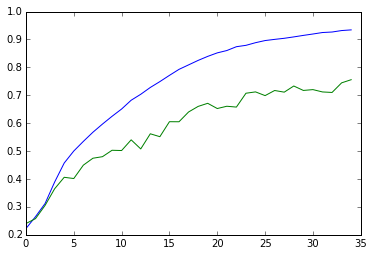

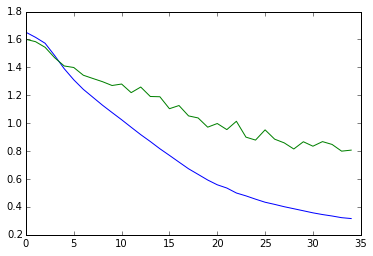

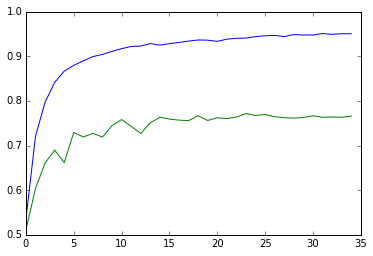

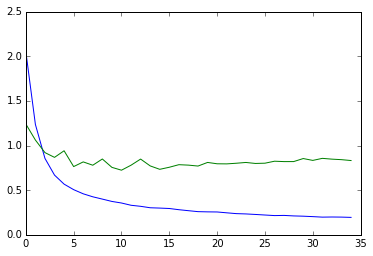

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
print results[0]['lstm_history']['val_accuracies'][-1]
print results[0]['mlp_history']['val_accuracies'][-1]
print results[0]['mlp_history'].keys()
plt.plot(results[0]['lstm_history']['train_accuracies'])
plt.plot(results[0]['lstm_history']['val_accuracies'])
plt.show()

plt.plot(results[0]['lstm_history']['train_losses'])
plt.plot(results[0]['lstm_history']['val_losses'])
plt.show()


plt.plot(results[0]['mlp_history']['train_accuracies'])
plt.plot(results[0]['mlp_history']['val_accuracies'])
plt.show()

plt.plot(results[0]['mlp_history']['train_losses'])
plt.plot(results[0]['mlp_history']['val_losses'])
plt.show()


In [9]:
import numpy as np
data_set_locations = ["RSVP_Color116msVPicr.mat",
                      "RSVP_Color116msVPpia.mat",
                      "RSVP_Color116msVPfat.mat",
                      "RSVP_Color116msVPgcb.mat",
                      "RSVP_Color116msVPgcc.mat",
                      "RSVP_Color116msVPgcd.mat",
                      "RSVP_Color116msVPgcf.mat",
                      "RSVP_Color116msVPgcg.mat",
                      "RSVP_Color116msVPgch.mat",
                      "RSVP_Color116msVPiay.mat",
                      "RSVP_Color116msVPicn.mat"];
lstm_accuracy = []
mlp_accuracy = []
for i, subject_name in enumerate(data_set_locations):
    file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
    gcd_res = readCompleteMatFile(file_name)
    jitter = 0
#     for jitter in range(-50,50,25):
    single_subject_test_data, single_subject_test_tags = create_letter_test_data_color(gcd_res, down_samples_param=8,jitter=jitter)
    model_lstm.set_weights(results[i]['lstm_history']['weights'])
    model_mpl.set_weights(results[i]['mlp_history']['weights'])
    lstm_eval_res = model_lstm.evaluate(stats.zscore(single_subject_test_data, axis=1),single_subject_test_tags, show_accuracy=True)
    mlp_eval_res = model_mpl.evaluate(stats.zscore(single_subject_test_data, axis=1),single_subject_test_tags, show_accuracy=True)
    print lstm_eval_res
    print mlp_eval_res
    lstm_accuracy.append([subject_name,lstm_eval_res[1]])
    mlp_accuracy.append([subject_name,mlp_eval_res[1]])
    


(18600L, 200L, 55L)
5400/5400 [==============================] - 0s     
[0.7227054717805651, 0.78629629629629627]
[0.27781800543820417, 0.91000000000000003]
(20700L, 200L, 55L)
7500/7500 [==============================] - 0s     
[0.33644002221425373, 0.89826666666666666]
[0.080946023495992031, 0.97266666666666668]
(18600L, 200L, 55L)
5400/5400 [==============================] - 0s     
[0.38728941131521155, 0.88574074074074072]
[0.21753094720619695, 0.93296296296296299]
(19500L, 200L, 55L)
6300/6300 [==============================] - 0s     
[0.27452504216678558, 0.91698412698412701]
[0.12580730973728119, 0.95793650793650797]
(18300L, 200L, 55L)
5100/5100 [==============================] - 0s     
[0.46234185920042148, 0.84745098039215683]
[0.16313615471709009, 0.94215686274509802]
(21000L, 200L, 55L)
7800/7800 [==============================] - 0s     
[0.6496944074141674, 0.79820512820512823]
[0.38790197985294539, 0.87974358974358979]
(18600L, 200L, 55L)
5400/5400 [================

In [13]:
print accuracy

[['RSVP_Color116msVPicr.mat', 0.78629629629629627], ['RSVP_Color116msVPpia.mat', 0.89826666666666666], ['RSVP_Color116msVPfat.mat', 0.88574074074074072], ['RSVP_Color116msVPgcb.mat', 0.91698412698412701], ['RSVP_Color116msVPgcc.mat', 0.84745098039215683], ['RSVP_Color116msVPgcd.mat', 0.79820512820512823], ['RSVP_Color116msVPgcf.mat', 0.38574074074074072], ['RSVP_Color116msVPgcg.mat', 0.30320512820512818], ['RSVP_Color116msVPgch.mat', 0.45819444444444446], ['RSVP_Color116msVPiay.mat', 0.31133333333333335], ['RSVP_Color116msVPicn.mat', 0.77700000000000002]]


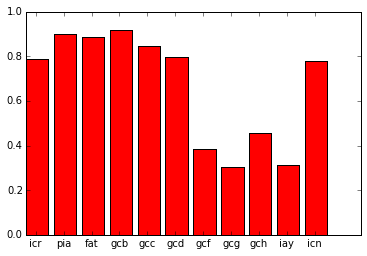

In [46]:
fig, ax = plt.subplots()

ind = np.arange(len(lstm_accuracy))
width = 0.35

rects1 = ax.bar(ind,[x[1]for x in lstm_accuracy],color='r')
ax.set_xticks(ind + width)
ax.set_xticklabels([x[0][-7:-4] for x in lstm_accuracy])
plt.show()

In [21]:
[x[1]for x in lstm_accuracy]

[0.78629629629629627,
 0.89826666666666666,
 0.88574074074074072,
 0.91698412698412701,
 0.84745098039215683,
 0.79820512820512823,
 0.38574074074074072,
 0.30320512820512818,
 0.45819444444444446,
 0.31133333333333335,
 0.77700000000000002]